### differents $B_\theta$, petits $\theta$, differents $sf_0$

In [1]:
import os

In [2]:
%mkdir -p tmp

In [3]:
data_folder = os.path.join('..', 'Psychopy_data', 'pilot', 'sf_0')
print('data_folder =', data_folder)

data_folder = ..\Psychopy_data\pilot\sf_0


In [4]:
%mkdir -p {data_folder}

Un sous-r‚pertoire ou un fichier -p existe d‚j….
Une erreur s'est produite lors du traitement deÿ: -p.
Un sous-r‚pertoire ou un fichier ..\Psychopy_data\pilot\sf_0 existe d‚j….
Une erreur s'est produite lors du traitement deÿ: ..\Psychopy_data\pilot\sf_0.


In [5]:
import numpy as np
N_sf =  1
N_B_theta = 10
B_thetas = np.pi/3*np.linspace(0, 1, N_B_theta+1)[1:]
B_thetas, 180/np.pi*B_thetas

(array([0.10471976, 0.20943951, 0.31415927, 0.41887902, 0.52359878,
        0.62831853, 0.73303829, 0.83775804, 0.9424778 , 1.04719755]),
 array([ 6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]))

In [6]:
%matplotlib inline

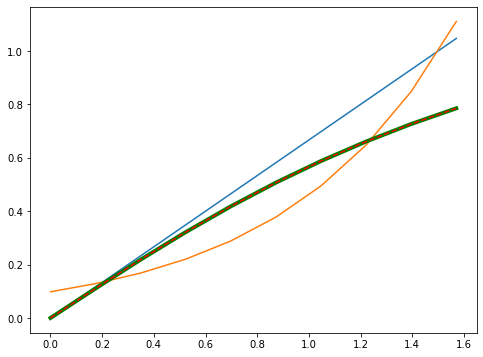

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(8,6)) 
ax.plot(np.pi/2*np.linspace(0, 1, N_B_theta), np.pi/3*np.linspace(0, 1, N_B_theta))
ax.plot(np.pi/2*np.linspace(0, 1, N_B_theta), np.pi*np.logspace(-5, -1.5, N_B_theta, base=2))
ax.plot(np.pi/2*np.linspace(0, 1, N_B_theta), np.arctan(np.linspace(0, 1, N_B_theta)), 'g', lw=4)
ax.plot(np.pi/2*np.linspace(0, 1, N_B_theta), np.arctan2(np.linspace(0, 1, N_B_theta), 1), 'r--')

In [8]:
%%writefile tmp/60_testing_different_sf.py
import sys
import numpy as np
import os
import imageio
import sys

data_folder = sys.argv[1]
print('\n Initializing')

N_B_theta = int(sys.argv[2])
N_sf = int(sys.argv[3])
N_trial = int(sys.argv[4])

B_thetas = np.pi/3*np.linspace(0, 1, N_B_theta+1)[1:]
print('B_thetas = ', B_thetas)
sfs = np.logspace(-1, -3, N_sf, base=2)
print('sfs = ', sfs)
theta_max = np.pi/8

N_total_trials = N_trial * N_B_theta * N_sf      # number of trials
fixation_length = 0.25  # length of fixation, in second
stim_length = 0.25   # length of stim, in second

seed = 2020
np.random.seed(seed)

thetas = np.linspace(-theta_max, theta_max, N_trial)
thetas = np.ravel(thetas[None, :] * np.ones((N_B_theta * N_sf, 1)))
conditions = np.ravel(np.arange(N_B_theta * N_sf)[:, None] * np.ones((1, N_trial))).astype(np.int)
ind = np.random.permutation(np.arange(N_total_trials))

thetas = thetas[ind]
conditions = conditions[ind]
i_sfs, i_B_thetas = conditions // N_B_theta, conditions % N_B_theta
i_sfs, i_B_thetas = i_sfs.astype(np.int), i_B_thetas.astype(np.int)

# generate all clouds

def generate_random_cloud(theta, B_theta, sf_0, seed, downscale = 1):
    fname = 'tmp/%s_%s_%s_%s.png' % (theta, B_theta, sf_0, seed)
    if not os.path.isfile(fname):
        import MotionClouds as mc
        fx, fy, ft = mc.get_grids(mc.N_X/downscale, mc.N_Y/downscale, 1)
        mc_i = mc.envelope_gabor(fx, fy, ft, V_X=0., V_Y=0.,
                                 B_V=0, theta=np.pi/2-theta, B_theta=B_theta)
        im = mc.random_cloud(mc_i, seed=seed)
        im = (mc.rectif(im) * 255).astype('uint8')
        imageio.imwrite(fname, im[:, :, 0])
    return fname

for i_trial in range(N_total_trials):
    #print(i_B_thetas.shape)
    #print(B_thetas.shape)
    #print(thetas[i_trial])
    #print(i_B_thetas[i_trial])
    #print(B_thetas[i_B_thetas[i_trial]])
    MC = generate_random_cloud(thetas[i_trial], 
                               B_theta=B_thetas[i_B_thetas[i_trial]], 
                               sf_0=sfs[i_sfs[i_trial]], 
                               seed=seed+i_trial) 

if len(sys.argv)>5:
    exp_observer = sys.argv[5]

    exp_name = "Perception de l'orientation"
    
    fullscr = False
    fullscr = True


    from psychopy import visual, core, event
    win = visual.Window([1400, 800], fullscr=fullscr, color=[0, 0, 0])


    mouse = event.Mouse(newPos=(0, 0), visible=False)
    x0, y0 = mouse.getPos()
    event.clearEvents()
    instructions = """
    At each trial you see one textured image, report the 
    orientation you perceive.

    Move the mouse to the right if it is clock-wise of the vertical,
    move the mouse to the left if it is counter clock-wise of the vertical.

    Move the mouse to begin the experiment.
    """
    msg = visual.TextStim(win, text=instructions, alignHoriz='center', alignVert='center', color='black')
    msg.draw()
    win.flip()
    while not mouse.mouseMoved(distance=.05): 
        event.clearEvents()
    fixation = visual.TextStim(win, text='Ready?', alignHoriz='center', alignVert='center', color='black')
    #fixation = visual.ShapeStim(vertices='cross', win=win, size=0.05, pos=[0, 0], fillColor='black', units='height')
    #fixation.autolog = False

    bitmap = visual.ImageStim(win, MC, mask='gauss', size=0.8, units='height', interpolate=True)
    bitmap.autolog = False 

    import time
    start_time = time.time()
    print("Test started")
    msg.setText('+')
    ans_list = []
    # run experiment
    for i_trial in range(N_total_trials):
        clock = core.Clock()
        if i_trial % N_trial:
            fixation.setText(f'{i_trial:03d}/{N_total_trials:03d}')
        else:
            fixation.setText(f'.')
        fixation.draw()
        win.flip()

        MC = generate_random_cloud(thetas[i_trial], 
                           B_theta=B_thetas[i_B_thetas[i_trial]], 
                           sf_0=sfs[i_sfs[i_trial]], 
                           seed=seed+i_trial)
        bitmap.setImage(MC)

         # Times the trial
        while clock.getTime() < fixation_length + stim_length:
            if clock.getTime() < fixation_length:  # fixation
                fixation.draw()
            elif clock.getTime() < fixation_length + stim_length: 
                bitmap.draw()
            win.flip()

        mouse.setPos(newPos=(0, 0))
        mouse.setVisible(True)
        x0, y0 = mouse.getPos()
        event.clearEvents()
        
        msg.draw()
        win.flip()

        while not mouse.mouseMoved(distance=.015): 
            # this creates a never-ending loop
            # until we move the mouse
            event.clearEvents()
        mouse.setVisible(False)

        RT = clock.getTime()

        x, y = mouse.getPos()
        if x < 0:
            answer = 'left'
        else: #elif x > 0:
            answer = 'right'
            if x == 0: print('this should not happen 😤')
        event.clearEvents() 

        ans = event.getKeys()       

        if ans == ['escape', 'q']:
            win.close()
            core.quit()

        correct = ((thetas[i_trial] > 0) and answer == 'right') or ((thetas[i_trial] < 0) and answer == 'left')
        print('At trial ', i_trial, 'Angle=', '%3.3f' % (thetas[i_trial]*180/np.pi), 'answer is ',  answer, '(correct=', correct, ');')   

        ans_list.append([i_trial, thetas[i_trial], answer, 
                         B_thetas[i_B_thetas[i_trial]], sfs[i_sfs[i_trial]], 
                         int(i_B_thetas[i_trial]), int(i_sfs[i_trial]), RT])
    
    print('saving')
    import json
    with open(os.path.join(data_folder, f'Psychophys_discrim_{exp_observer}.json'), 'w') as fp:
        json.dump(ans_list, fp)

    print('exiting')
    event.clearEvents() 
    win.close()
    core.quit()


Writing tmp/60_testing_different_sf.py


In [9]:
!ipython tmp/60_testing_different_sf.py {data_folder} 5 5 18


 Initializing
B_thetas =  [0.20943951 0.41887902 0.62831853 0.83775804 1.04719755]
sfs =  [0.5        0.35355339 0.25       0.1767767  0.125     ]


#  stratified fold

In [10]:
import numpy as np
N_B_theta = 3
N_sf = 5

seed = 42
np.random.seed(seed)
N_trial = 4
N_total_trials = N_trial * N_B_theta * N_sf      # number of trials

theta_max = 20
thetas = np.linspace(-theta_max, theta_max, N_trial)
# thetas = np.ravel((2*np.random.rand(N_trial, 1)-1)*20 * np.ones(N_B_theta * N_B_sf))
thetas = np.ravel(thetas[None, :] * np.ones((N_B_theta * N_sf, 1)))
thetas


array([-20.        ,  -6.66666667,   6.66666667,  20.        ,
       -20.        ,  -6.66666667,   6.66666667,  20.        ,
       -20.        ,  -6.66666667,   6.66666667,  20.        ,
       -20.        ,  -6.66666667,   6.66666667,  20.        ,
       -20.        ,  -6.66666667,   6.66666667,  20.        ,
       -20.        ,  -6.66666667,   6.66666667,  20.        ,
       -20.        ,  -6.66666667,   6.66666667,  20.        ,
       -20.        ,  -6.66666667,   6.66666667,  20.        ,
       -20.        ,  -6.66666667,   6.66666667,  20.        ,
       -20.        ,  -6.66666667,   6.66666667,  20.        ,
       -20.        ,  -6.66666667,   6.66666667,  20.        ,
       -20.        ,  -6.66666667,   6.66666667,  20.        ,
       -20.        ,  -6.66666667,   6.66666667,  20.        ,
       -20.        ,  -6.66666667,   6.66666667,  20.        ,
       -20.        ,  -6.66666667,   6.66666667,  20.        ])

In [11]:
conditions = np.ravel(np.arange(N_B_theta * N_sf)[:, None] * np.ones(N_trial)).astype(np.int)
conditions

array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
        4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
        8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
       12, 13, 13, 13, 13, 14, 14, 14, 14])

In [12]:
conditions // N_B_theta, conditions % N_B_theta, (conditions // N_B_theta)*N_B_theta + conditions % N_B_theta

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32),
 array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2,
        2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1,
        2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2], dtype=int32),
 array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
         4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
         8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
        12, 13, 13, 13, 13, 14, 14, 14, 14], dtype=int32))

In [13]:
#np.random.shuffle(conditions)
conditions

array([ 0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,  4,
        4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,  7,  7,  8,  8,
        8,  8,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11, 12, 12, 12,
       12, 13, 13, 13, 13, 14, 14, 14, 14])

In [14]:
ind = np.random.permutation(np.arange(N_B_theta * N_sf*N_trial))
conditions = conditions[ind]
ind, conditions, thetas[ind]

(array([ 0,  5, 36, 45, 13, 54, 33, 48, 12, 57, 46, 50, 31,  3, 52, 17,  8,
         6, 40,  4, 43, 19, 34, 58, 25, 56, 15, 27,  9, 30, 26, 16, 24, 55,
        11, 32, 53, 41, 37, 29, 44,  1, 21,  2, 47, 39, 35, 23, 49, 10, 22,
        18, 59, 20,  7, 42, 14, 28, 51, 38]),
 array([ 0,  1,  9, 11,  3, 13,  8, 12,  3, 14, 11, 12,  7,  0, 13,  4,  2,
         1, 10,  1, 10,  4,  8, 14,  6, 14,  3,  6,  2,  7,  6,  4,  6, 13,
         2,  8, 13, 10,  9,  7, 11,  0,  5,  0, 11,  9,  8,  5, 12,  2,  5,
         4, 14,  5,  1, 10,  3,  7, 12,  9]),
 array([-20.        ,  -6.66666667, -20.        ,  -6.66666667,
         -6.66666667,   6.66666667,  -6.66666667, -20.        ,
        -20.        ,  -6.66666667,   6.66666667,   6.66666667,
         20.        ,  20.        , -20.        ,  -6.66666667,
        -20.        ,   6.66666667, -20.        , -20.        ,
         20.        ,  20.        ,   6.66666667,   6.66666667,
         -6.66666667, -20.        ,  20.        ,  20.        ,
    

In [15]:
conditions // N_B_theta, conditions % N_B_theta

(array([0, 0, 3, 3, 1, 4, 2, 4, 1, 4, 3, 4, 2, 0, 4, 1, 0, 0, 3, 0, 3, 1,
        2, 4, 2, 4, 1, 2, 0, 2, 2, 1, 2, 4, 0, 2, 4, 3, 3, 2, 3, 0, 1, 0,
        3, 3, 2, 1, 4, 0, 1, 1, 4, 1, 0, 3, 1, 2, 4, 3], dtype=int32),
 array([0, 1, 0, 2, 0, 1, 2, 0, 0, 2, 2, 0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1,
        2, 2, 0, 2, 0, 0, 2, 1, 0, 1, 0, 1, 2, 2, 1, 1, 0, 1, 2, 0, 2, 0,
        2, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1, 1, 0, 1, 0, 0], dtype=int32))

In [16]:
(conditions // N_B_theta)*N_B_theta + conditions % N_B_theta

array([ 0,  1,  9, 11,  3, 13,  8, 12,  3, 14, 11, 12,  7,  0, 13,  4,  2,
        1, 10,  1, 10,  4,  8, 14,  6, 14,  3,  6,  2,  7,  6,  4,  6, 13,
        2,  8, 13, 10,  9,  7, 11,  0,  5,  0, 11,  9,  8,  5, 12,  2,  5,
        4, 14,  5,  1, 10,  3,  7, 12,  9], dtype=int32)

## tests on psychopy

In [17]:
%%writefile tmp/test.py

from psychopy import visual, core
import time
fullscr = False
#win = visual.Window([1400,800],fullscr=fullscr, color=[0,0,0], winType='pygame', monitor='testMonitor', units='height')
win = visual.Window([1400, 800], fullscr=fullscr, color=[0, 0, 0])
msg = visual.TextStim(win, text='.', color='black')
msg.draw()
win.flip()
time.sleep(2)
msg.setText('toto')
msg.draw()
win.flip()
time.sleep(2)
print('exiting')
win.close()
core.quit()


Writing tmp/test.py


In [21]:
#!ipython tmp/test.py 

In [18]:
ind = 20
f'{ind:03d}'

'020'